In [120]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import random
from geopy.geocoders import Nominatim
import io
import matplotlib.colors as mcolors
import folium
import matplotlib.pyplot  as plt
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from IPython.display import display
import requests

# Verzamelen van Toegangstoken
In dit blok halen we een toegangstoken op voor de verbinding met de Sentinel Hub API. Dit token wordt later gebruikt om gegevens op te vragen.

In [121]:
CLIENT_ID = "cbd517e2-9cc3-45eb-9676-b7d819396197"
CLIENT_SECRET = "cE9yVPSLYDCON304gWDfZeDjLYE9SlpL"

# Set up credentials
client = BackendApplicationClient(client_id=CLIENT_ID)
oauth = OAuth2Session(client=client)

# Verkrijg het toegangstoken
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token',
                          client_secret=CLIENT_SECRET, include_client_id=True)


# Genereren van een Willekeurige Bounding Box en Locatie
Genereren van willekeurige bounding box binnen gespecificeerde geografische grenzen en haalt de bijbehorende locatie-naam op.

In [122]:
# Functie om een willekeurige bounding box binnen een bepaald gebied te genereren
def generate_random_bbox(lat_min, lat_max, lon_min, lon_max, max_size_deg=1.0):
    lat1 = random.uniform(lat_min, lat_max)
    lon1 = random.uniform(lon_min, lon_max)

    # Beperk de grootte van de bounding box
    lat2 = lat1 + random.uniform(-max_size_deg, max_size_deg)
    lon2 = lon1 + random.uniform(-max_size_deg, max_size_deg)
    
    bbox = [min(lon1, lon2), min(lat1, lat2), max(lon1, lon2), max(lat1, lat2)]
    return bbox

# Functie om de locatie-naam te verkrijgen via Geopy (Nominatim)
def get_location_name(lat, lon):
    geolocator = Nominatim(user_agent="random_bbox_app")
    location = geolocator.reverse((lat, lon), language='en')
    return location.address if location else "Onbekende locatie"

# Specificeer de grenzen voor willekeurige coördinaten (bijvoorbeeld voor Europa)
lat_min = 30.0  # Minimum breedtegraad
lat_max = 60.0  # Maximum breedtegraad
lon_min = 0.0  # Minimum lengtegraad
lon_max = 150.0  # Maximum lengtegraad

# Genereer een willekeurige bounding box
bbox_random = generate_random_bbox(lat_min, lat_max, lon_min, lon_max)
print(f"Willekeurige Bounding Box: {bbox_random}")

# Verkrijg de locatie-naam voor het middelpunt van de bounding box
center_lat = (bbox_random[1] + bbox_random[3]) / 2
center_lon = (bbox_random[0] + bbox_random[2]) / 2
location_name = get_location_name(center_lat, center_lon)

print(f"Locatie van het centrum van de bounding box: {location_name}")

# Print de coördinaten van het middelpunt
print(f"Centrum coördinaten: Breedtegraad {center_lat}, Lengtegraad {center_lon}")

Willekeurige Bounding Box: [136.7590096160515, 35.770543644551374, 137.5837297280387, 36.170817102072284]
Locatie van het centrum van de bounding box: Gero, Gifu Prefecture, Japan
Centrum coördinaten: Breedtegraad 35.97068037331183, Lengtegraad 137.1713696720451


# Verzoek naar Sentinel Hub API voor Satellietdata
Een verzoek maken naar de Sentinel Hub API om satellietafbeeldingen te verkrijgen voor een willekeurige bounding box. Het haalt de data op in de vorm van een composietafbeelding met de banden voor rood, groen, blauw en nabij-infrarood.

In [123]:
def fetch_images_for_training(bbox, start_date, end_date, num_images=10):
    images = []
    collection_id = "sentinel-2-l2a"

    evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: ["B04", "B03", "B02", "B08"],  // Voeg B8 (NIR) toe
            output: {
                bands: 4,
                sampleType: "AUTO"
            }
        }
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02, sample.B08]; // Retourneer de juiste banden
    }
    """

    # Haal meerdere afbeeldingen op
    for i in range(num_images):
        json_request = {
            'input': {
                'bounds': {
                    'bbox': bbox,
                    'properties': {
                        'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'
                    }
                },
                'data': [
                    {
                        'type': collection_id,
                        'dataFilter': {
                            'timeRange': {
                                'from': start_date,
                                'to': end_date
                            },
                            'mosaickingOrder': 'leastCC',
                        },
                    }
                ]
            },
            'output': {
                'width': 1024,
                'height': 1024,
                'responses': [
                    {
                        'identifier': 'default',
                        'format': {
                            'type': 'image/tiff',
                        }
                    }
                ]
            },
            'evalscript': evalscript
        }

        url_request = "https://services.sentinel-hub.com/api/v1/process"
        headers_request = {
            "Authorization": f"Bearer {token['access_token']}"
        }
        response = oauth.request("POST", url_request, headers=headers_request, json=json_request)

        if response.status_code == 200:
            print(f"Afbeelding {i+1} succesvol opgehaald!")
            img_data = response.content
            images.append(img_data)
        else:
            print(f"Fout bij API-aanroep voor afbeelding {i+1}: {response.status_code}")
            print(response.text)
    
    return images

# Haal 10 afbeeldingen op voor training
start_date = "2023-01-01T00:00:00Z"  # Gebruik het ISO-8601 formaat inclusief tijd en tijdzone
end_date = "2023-06-01T00:00:00Z"    # Gebruik het ISO-8601 formaat inclusief tijd en tijdzone
images = fetch_images_for_training(bbox_random, start_date, end_date, num_images=10)

Afbeelding 1 succesvol opgehaald!
Afbeelding 2 succesvol opgehaald!
Afbeelding 3 succesvol opgehaald!
Afbeelding 4 succesvol opgehaald!
Afbeelding 5 succesvol opgehaald!
Afbeelding 6 succesvol opgehaald!
Afbeelding 7 succesvol opgehaald!
Afbeelding 8 succesvol opgehaald!
Afbeelding 9 succesvol opgehaald!
Afbeelding 10 succesvol opgehaald!


# Verwerken en Visualiseren van Satellietdata
De ontvangen satellietdata openen, de banden van de afbeelding geëxtraheerd en de NDVI (Normalized Difference Vegetation Index) berekend. Vervolgens worden de originele afbeelding en de NDVI-uitvoer gevisualiseerd.

In [124]:
def find_ndvi(img_data):
    with rasterio.open(io.BytesIO(img_data)) as src:
        red = src.read(1) / 255.0
        nir = src.read(4) / 255.0
    ndvi = (nir - red) / (nir + red + 1e-5)
    ndvi = np.nan_to_num(ndvi, nan=-1, posinf=-1, neginf=-1)
    return ndvi

ndvi_images = [find_ndvi(img) for img in images]
for img_print in ndvi_images:
    print(img_print)

[[0.2183876  0.03448242 0.0640386  ... 0.13845973 0.19539944 0.22608445]
 [0.0170647  0.62788836 0.66290236 ... 0.16762759 0.14130239 0.31371765]
 [0.0170647  0.62788836 0.66290236 ... 0.01290312 0.07169742 0.35134328]
 ...
 [0.3571266  0.35482412 0.36362231 ... 0.70367047 0.62854853 0.79744261]
 [0.36665108 0.37703342 0.36840457 ... 0.63633905 0.73767408 0.61400762]
 [0.36665108 0.37703342 0.36840457 ... 0.72304856 0.69441985 0.799966  ]]
[[0.2183876  0.03448242 0.0640386  ... 0.13845973 0.19539944 0.22608445]
 [0.0170647  0.62788836 0.66290236 ... 0.16762759 0.14130239 0.31371765]
 [0.0170647  0.62788836 0.66290236 ... 0.01290312 0.07169742 0.35134328]
 ...
 [0.3571266  0.35482412 0.36362231 ... 0.70367047 0.62854853 0.79744261]
 [0.36665108 0.37703342 0.36840457 ... 0.63633905 0.73767408 0.61400762]
 [0.36665108 0.37703342 0.36840457 ... 0.72304856 0.69441985 0.799966  ]]
[[0.2183876  0.03448242 0.0640386  ... 0.13845973 0.19539944 0.22608445]
 [0.0170647  0.62788836 0.66290236 ... 

# Machine Learning Model voor NDVI Voorspelling
Random Forest-regressor gebruiken om de NDVI te voorspellen op basis van de bestaande kenmerken van de afbeelding.

In [125]:
# Flatten NDVI images for model input
X = []
y = []

# Flatten the NDVI images for the first 9 images (for training)
for ndvi in ndvi_images[:-1]:  # Use the first 9 images for training
    X.append(ndvi.flatten())  # Flatten the image into a 1D array
    y.append(ndvi.flatten())  # The target is the same flattened NDVI values

X = np.array(X)
y = np.array(y)

# Train a model to predict the NDVI values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# Use the model to predict the 10th image
latest_ndvi = ndvi_images[-1]  # The 10th image

# Flatten the 10th image
X_pred = latest_ndvi.flatten().reshape(1, -1)

# Predict the NDVI values for the 10th image
y_pred = model.predict(X_pred)

# Reshape the predicted values back into the original NDVI shape
predicted_ndvi = y_pred.reshape(latest_ndvi.shape)

# Clip predicted NDVI to valid range [-1, 1]
predicted_ndvi = np.clip(predicted_ndvi, -1, 1)

# Display or save the predicted NDVI image
print(predicted_ndvi)

# Evaluate the accuracy on the test set
y_test_pred = model.predict(X_test)

# Compute accuracy metrics
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

[[0.2183876  0.03448242 0.0640386  ... 0.13845973 0.19539944 0.22608445]
 [0.0170647  0.62788836 0.66290236 ... 0.16762759 0.14130239 0.31371765]
 [0.0170647  0.62788836 0.66290236 ... 0.01290312 0.07169742 0.35134328]
 ...
 [0.3571266  0.35482412 0.36362231 ... 0.70367047 0.62854853 0.79744261]
 [0.36665108 0.37703342 0.36840457 ... 0.63633905 0.73767408 0.61400762]
 [0.36665108 0.37703342 0.36840457 ... 0.72304856 0.69441985 0.799966  ]]
Mean Absolute Error (MAE): 2.918974049313371e-16
R-squared (R²): 0.10297298431396484
Root Mean Squared Error (RMSE): 3.8516582008175357e-16


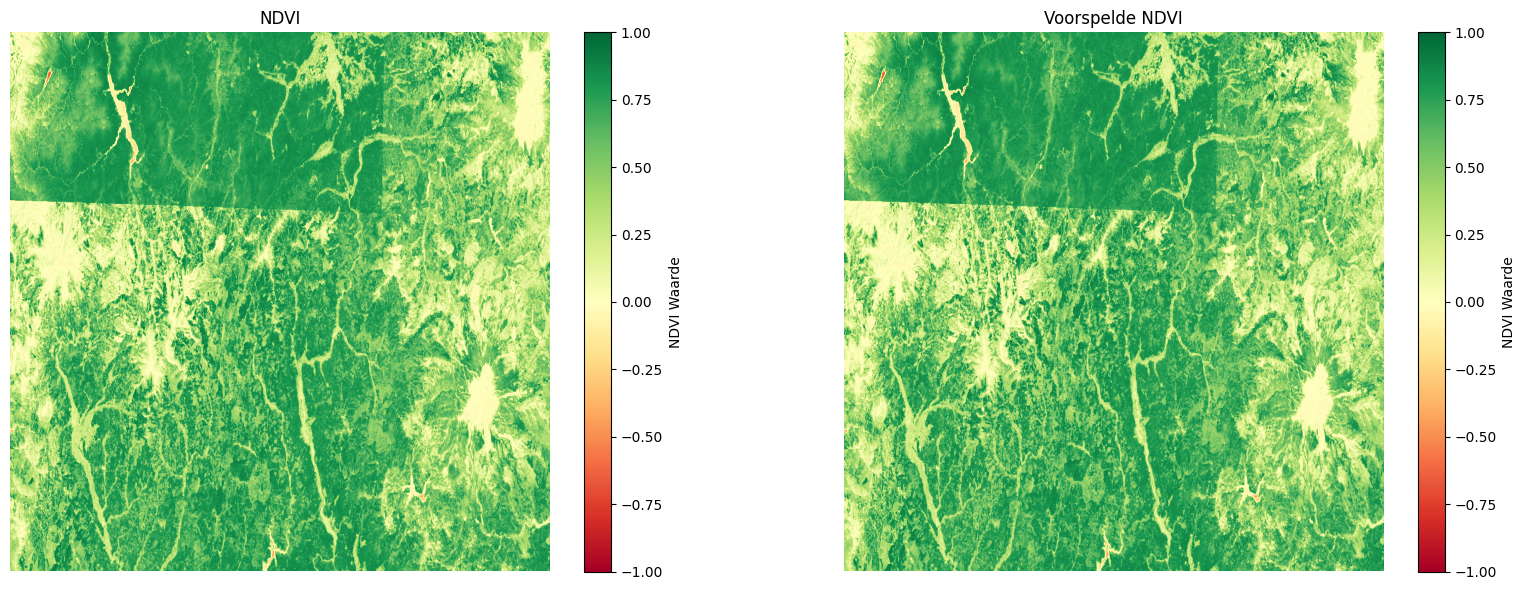

Gero, Gifu Prefecture, Japan


In [126]:
def visualize_ndvi_and_prediction(ndvi, predicted_ndvi, location_name, center_lat, center_lon):
    # Set the color map for NDVI visualization
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = plt.cm.RdYlGn

    # Create subplots for the images
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # NDVI image
    im = axes[0].imshow(ndvi, cmap=cmap, norm=norm)  # Use axes[0] for the first subplot
    axes[0].set_title("NDVI")
    axes[0].axis('off')

    # Add a colorbar next to the NDVI plot
    cbar = plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
    cbar.set_label('NDVI Waarde')

    # Predicted NDVI
    im_pred = axes[1].imshow(predicted_ndvi, cmap=cmap, norm=norm)  # Use axes[1] for the second subplot
    axes[1].set_title("Voorspelde NDVI")
    axes[1].axis('off')

    # Add a colorbar next to the Predicted NDVI plot
    cbar = plt.colorbar(im_pred, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_label('NDVI Waarde')

    plt.tight_layout()
    plt.show()

    # Create a Folium map for the location with a satellite-like layer (Esri satellite)
    map = folium.Map(location=[center_lat, center_lon], zoom_start=10)  # Create the map object first

    # Add Esri Satellite tile layer
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Esri Satellite',
        overlay=False,
        control=True
    ).add_to(map)

    # Add a marker for the location with location name in the popup
    folium.Marker([center_lat, center_lon], popup=location_name).add_to(map)

    # Fetch country borders (GeoJSON data)
    try:
        # Using a working source for country borders (natural earth data)
        url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/countries.geojson"
        response = requests.get(url)

        # Check if the response status is OK and parse the content
        if response.status_code == 200:
            countries_geo = response.json()  # Parse the GeoJSON
            folium.GeoJson(countries_geo, name="Country Borders", overlay=True).add_to(map)
        else:
            print(f"Error fetching GeoJSON: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as e:
        print(f"Failed to decode JSON: {e}")

    # Add a control layer to show/hide the country borders
    folium.LayerControl().add_to(map)

    # Add Google Maps link to location
    google_maps_url = f"https://www.google.com/maps/@{center_lat},{center_lon},15z"  # Modify the zoom level as needed
    folium.Marker([center_lat, center_lon], popup=f'<a href="{google_maps_url}" target="_blank">Open in Google Maps</a>').add_to(map)

    # Display the map directly in the notebook
    print(location_name)
    display(map)

# Example call with the correct image data and parameters
visualize_ndvi_and_prediction(ndvi_images[-1], predicted_ndvi, location_name, center_lat, center_lon)
